# mini-auspex example: immersion TFM

This Notebook is a suplementary material to the paper **mini-auspex: a Python library for ultrasonic data import, post-processing, and image reconstruction**, presented at the 14th European Conference on Non-Destructive Testing (ECNDT 2026).

The objective is to to provide a fully functional exemplary utilization of the Total Focusing Method (TFM) imaging algorithm from the <a href='https://pypi.org/project/mini-auspex/'>mini-auspex</a> Python library.

The test data was acquired using an <a href='https://www.eddyfi.com/en/news/eddyfi-technologies-officially-launches-m2m-panther'>M2M Panther</a> acquisition system (Eddify Technologies) and a Phased Array (PA) probe model 5L64-A32 (Evident Scientific). The figure below (left side) shows the steup: the PA was positioned at at distance of ~25 mm from the surface of the carbon steel sample. The sample contains side drilled holes, which we intend to image. In the right side, the resulting TFM image is displayed. By following the steps of this Notebook, you will be able to generate that image using Matplotlib.

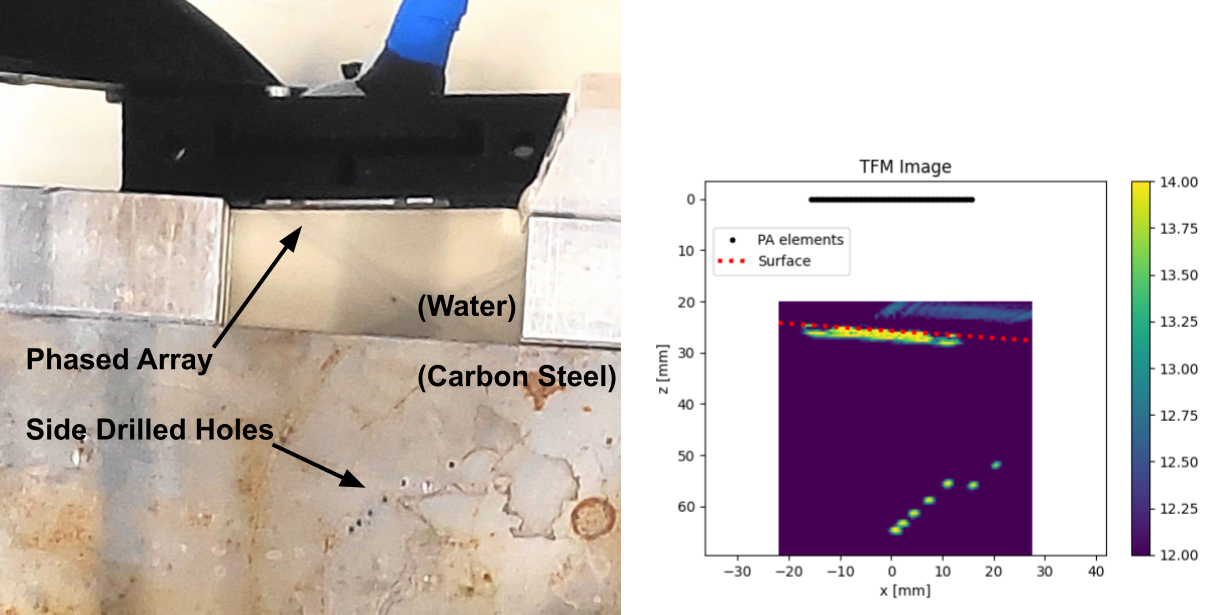

The flowchart was extracted from the paper, and summarizes the steps that you are going to perform. Shaded boxes represent procedures performed using classes and functions from the mini-auspex library.

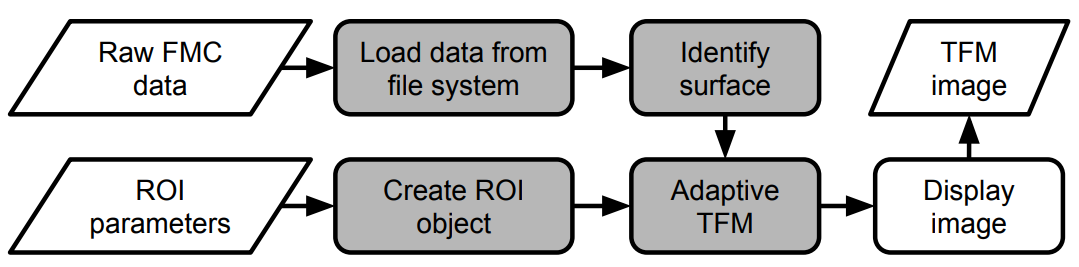

### Install mini-auspex
Use pip command to install the <a href='https://pypi.org/project/mini-auspex/'>mini-auspex</a> library from the PiPy repository.

In [ ]:
!pip install mini-auspex

### Download the data
Since we are using a Google Colab Notebook, we will download the data using <a href='https://pypi.org/project/gdown/'>gdown</a>. Alternatively, you can upload the the data to the virtual file system of the Notebook.

In [ ]:
import gdown

url = 'https://drive.google.com/drive/folders/1s-M9zNB6XcHKxcctG1zvrb8xEVjxBiA3?usp=sharing'
gdown.download_folder(url, quiet=True)
print('The data is now available in the virtual file system.');

The data is now available in the virtual file system.


### Load the data as a DataInsp object
We use the <a href='https://lassip-utfpr.github.io/webauspex/docs/framework.file_m2k.html'>file_m2k</a> module from mini-auspex library to load the inspection data acquired using the M2M Panther system. The complete data is loaded as a <a href='https://lassip-utfpr.github.io/webauspex/docs/framework.data_types.html#framework.data_types.DataInsp'>DataInsp</a> object. Then, we show a B-scan visualization of the ultrasonic signals, as well as part of the A-scan corresponding to the first element of the array operating as both emitter and receiver.

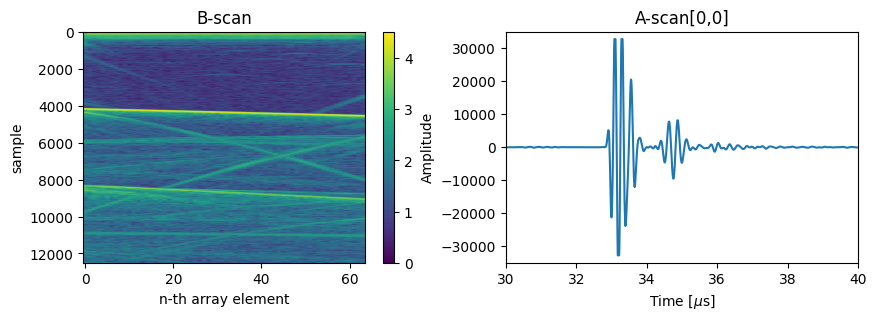

In [ ]:
from framework import file_m2k
import matplotlib.pyplot as plt
import numpy as np

# Load the M2M Panther data
data = file_m2k.read('immersion_fmc_rot_Xdeg.m2k', freq_transd=5,
                     bw_transd=0.5, tp_transd='gaussian', sel_shots=0)
# Correct the inspection type, which was wrongly informed
# when the acquisition was realized.
data.inspection_params.type_insp = 'immersion'

# Create B-scan visualization
b_scan = np.zeros((data.ascan_data.shape[0], data.ascan_data.shape[2]),
                  dtype=float)
for i in range(b_scan.shape[1]):
  b_scan[:, i] = data.ascan_data[:, i, i, 0]

# Display B-scan (log scale)
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.imshow(np.log10(np.abs(b_scan)+1e0), aspect='auto')
plt.colorbar()
plt.xlabel('n-th array element')
plt.ylabel('sample')
plt.title('B-scan')

plt.subplot(1,2,2)
plt.plot(data.time_grid, b_scan[:, 0])
plt.axis([30, 40, -35000, 35000])
plt.xlabel('Time [$\\mu$s]')
plt.ylabel('Amplitude')
plt.title('A-scan[0,0]');

### Identify the surface
Now we identify the surface, i.e., the interface between the coupling medium (water) and the inspected object (carbon steel). The class <a href='https://lassip-utfpr.github.io/webauspex/docs/surface.surface.html#surface.surface.Surface'>Surface</a> is used for the identification from the A-scan data. Later on, the identified surface will be used by the TFM algorithm.

A schematic plot shows the position of the identified surface relative to the Phased Array. The plot also shows the Region of Interest (ROI), i.e., the set of pixels for which the image will be reconstructed. The ROI is defined using the <a href='https://lassip-utfpr.github.io/webauspex/docs/framework.data_types.html#framework.data_types.ImagingROI'>ImagingROI</a> class.

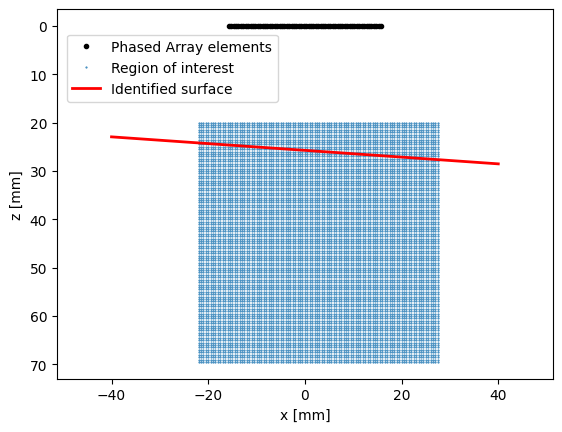

In [ ]:
from surface.surface import Surface, SurfaceType
from framework.data_types import ImagingROI

# Create Surface Object
mySurf = Surface(data, 0, keep_data_insp=False)
# Fit a flat (linear) surface from A-scan data
mySurf.fit(surf_type=SurfaceType.LINE_LS)
# Add the Surface object to the DataInsp object
# (this is necessary for TFM)
data.surf = mySurf

# Shows the position of the PA elements
plt.plot(data.probe_params.elem_center[:, 0],
         data.probe_params.elem_center[:, 2],
         'k.', label='Phased Array elements')

# --- ROI ---
# Defines a 50 mm x 50 mm ROI with 100 x 100 pixels.
height = 50.0
width = 50.0
w_len=100
h_len=100
corner_roi = np.array([[-22.0, 0.0, 20.0]])
roi = ImagingROI(corner_roi,
                 height=height, width=width,
                 w_len=w_len, h_len=h_len)
plt.plot(roi.get_coord()[:, 0],
         roi.get_coord()[:, 2],
         '.', label='Region of interest',
         markersize=1)

# Plots the identified surface.
a = mySurf.surfaceparam.a
b = mySurf.surfaceparam.b
plt.plot([-40, 40],
 [-40*a+b, 40*a+b],
         'r', linewidth=2,
         label='Identified surface')
plt.gca().invert_yaxis()
plt.xlabel('x [mm]')
plt.ylabel('z [mm]')
plt.axis('equal')
plt.legend(loc=(.02,.75));

### Create the TFM image

Now we perform imaging of the ROI using the Total Focusing Method (TFM), which is implemented in the <a href='https://lassip-utfpr.github.io/webauspex/docs/imaging.tfm.html'>tfm</a> module. Notice that one of the arguments for TFM is the ImagingROI object defined previously.

We display the resulting TFM image. We also plot the positions of the elements of the Phased Array as well as the identified surface for reference.

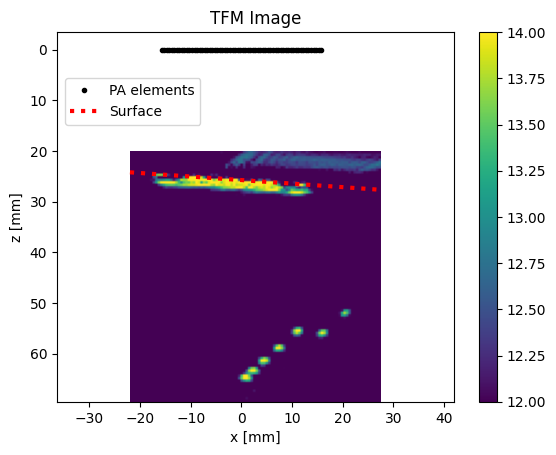

In [ ]:
from imaging import tfm
from framework.data_types import ImagingROI

# Gets the TFM image.
tfm_key = tfm.tfm_kernel(data, roi, analytic=True)
tfm_img = data.imaging_results[tfm_key].image

# Exhibits the TFM image.
plt.imshow(np.log(np.abs(tfm_img)), aspect='auto',
           extent=[roi.w_points[0], roi.w_points[-1],
                   roi.h_points[-1], roi.h_points[0]],
           vmin=12, vmax=14)
plt.colorbar()
plt.title('TFM Image')

# Shows the position of the PA elements
plt.plot(data.probe_params.elem_center[:, 0],
         data.probe_params.elem_center[:, 2],
         'k.', label='PA elements')
# Plots the identified surface.
plt.plot([roi.w_points[0], roi.w_points[-1]],
 [roi.w_points[0]*a+b, roi.w_points[-1]*a+b],
         'r:', linewidth=3,
         label='Surface')
plt.axis('equal')
plt.xlabel('x [mm]')
plt.ylabel('z [mm]')
plt.legend(loc=(.02,.75));

### Create another TFM image (zooming in)

Now we define a new ImagingROI object, zooming in a small region of 25 mm x 30 mm where the side drilled holes of the inspected object are concentrated.


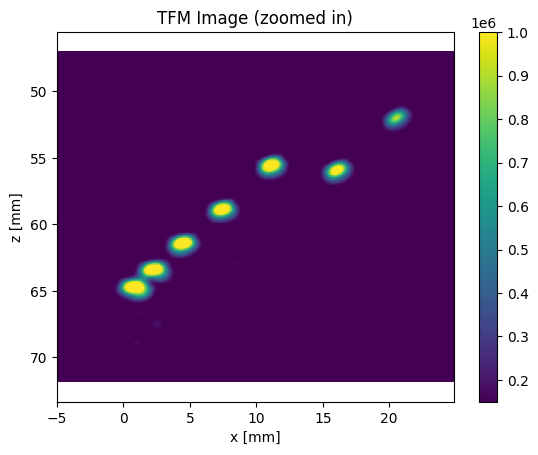

In [ ]:
from framework.data_types import ImagingROI

# --- ROI ---
# Defines a 25 mm x 30 mm ROI.
height = 25.0
width = 30.0
w_len=200
h_len=200
corner_roi = np.array([[-5.0, 0.0, 47.0]])
roi_zoomed = ImagingROI(corner_roi,
                 height=height, width=width,
                        w_len=w_len, h_len=h_len)

# Gets the TFM image.
tfm_key = tfm.tfm_kernel(data, roi_zoomed, analytic=True)
tfm_zoomed = data.imaging_results[tfm_key].image

# Displays the TFM image
plt.imshow(np.abs(tfm_zoomed), aspect='auto',
                   extent=[roi_zoomed.w_points[0],
                           roi_zoomed.w_points[-1],
                   roi_zoomed.h_points[-1],
                   roi_zoomed.h_points[0]],
           vmin=1.5e5, vmax=1e6)
plt.colorbar()
plt.axis('equal')
plt.xlabel('x [mm]')
plt.ylabel('z [mm]')
plt.title('TFM Image (zoomed in)');